# **import Libraries**

In [92]:
# Ignoring any warning messages
import warnings
warnings.filterwarnings('ignore')

In [72]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision.transforms as transforms


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from collections import Counter

# **Create Data Matrix & Labels**

In [73]:
index = 0

data = np.zeros((400, 10304))
labels = np.zeros(400)

for folder_name in os.listdir("/kaggle/input/att-database-of-faces"):
    if folder_name == "README":
        continue

    root_path = "/kaggle/input/att-database-of-faces/" + folder_name
    
    for img in os.listdir(root_path):
        img = np.asarray(Image.open(root_path +  "/" +  img))
        img = img / 255.0
        
        flatten_img = np.ravel(img)
        data[index] = flatten_img
        
        labels[index] = int(folder_name[1:])

        index += 1

# **Split Data Into Train and Test**

In [74]:
X_train = train_data   = data[::2]
y_train = train_labels = labels[::2]
y_train = y_train.astype(int)

X_test = test_data   = data[1::2]
y_test = test_labels = labels[1::2]
y_test = y_test.astype(int)

# **PCA (Omar)**

In [75]:
class PCA:
    
    def __init__(self):
        self.mean = None
        self.eig_vecs = None
        self.eig_vals = None


    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_X = X - self.mean

        cov_mat = np.cov(centered_X, rowvar=False)

        eig_vals, eig_vecs = np.linalg.eig(cov_mat)

        self.eig_vecs = eig_vecs
        self.eig_vals = eig_vals

        sorted_indices = np.argsort(self.eig_vals)[::-1]

        self.eig_vals = self.eig_vals[sorted_indices]
        self.eig_vecs = self.eig_vecs[:, sorted_indices]

        
        np.save('eigenvalues.npy', self.eig_vals)
        np.save('eigenvectors.npy', self.eig_vecs)


        
    
    def reduce_dimensions(self, X, alpha):
        
        if self.eig_vals is None or self.eig_vecs is None:
            
            self.eig_vals = np.load('eigenvalues.npy')
            self.eig_vecs = np.load('eigenvectors.npy')
        
        centered_X = X - self.mean
        total_variance = np.sum(self.eig_vals)
        eigen_values_sum = 0
        num_components = 0
        for i in range(len(self.eig_vals)):

            if eigen_values_sum / total_variance < alpha:
                eigen_values_sum += self.eig_vals[i]
                num_components += 1
            else:
                break

        selected_eigenvectors = self.eig_vecs[:, :num_components]    
        X_reduced = np.dot(centered_X, selected_eigenvectors)

        print(f"Alpha: {alpha} -> Retained Dimensions: {num_components}")

        return X_reduced, selected_eigenvectors
    

    
    def visualize_reconstruction(self, X_reduced, eigenvectors_selected, X_original, num_samples):
    
        X_reconstructed = np.dot(X_reduced, eigenvectors_selected.T) + self.mean

        plt.figure(figsize=(10, 2))
        for i in range(num_samples):
        
            plt.subplot(2, num_samples, i+1)
            plt.imshow(X_original[i].reshape(92, 112), cmap='gray')
            plt.axis('off')
            plt.title("Original")

        
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(X_reconstructed[i].reshape(92, 112), cmap='gray')
            plt.axis('off')
            plt.title("Reconstructed")

        plt.suptitle('Original vs Reconstructed Faces from PCA Space')
        plt.show()

In [76]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=42) 
# print(f"Original train shape: {X_train.shape}")
# print(f"Original test shape: {X_test.shape}")
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# print(f"PCA-reduced train shape: {X_train.shape}")
# print(f"PCA-reduced test shape: {X_test.shape}")

In [77]:
reduced_trains = {}

pca = PCA()
pca.fit(X_train)

alphas = [0.8, 0.85, 0.9, 0.95]
num_samples = 5

for alpha in alphas:
    print(f"PCA transform for alpha = {alpha}")
    
    reduced_X_train, eigenvectors_selected = pca.reduce_dimensions(X_train, alpha)
    reduced_trains[alpha] = reduced_X_train

    print(f"Number of dimensions for alpha {alpha}: {reduced_X_train.shape[1]}")

PCA transform for alpha = 0.8
Alpha: 0.8 -> Retained Dimensions: 35
Number of dimensions for alpha 0.8: 35
PCA transform for alpha = 0.85
Alpha: 0.85 -> Retained Dimensions: 51
Number of dimensions for alpha 0.85: 51
PCA transform for alpha = 0.9
Alpha: 0.9 -> Retained Dimensions: 75
Number of dimensions for alpha 0.9: 75
PCA transform for alpha = 0.95
Alpha: 0.95 -> Retained Dimensions: 114
Number of dimensions for alpha 0.95: 114


In [78]:
reduced_tests = {}

pca = PCA()
pca.fit(X_test)

alphas = [0.8, 0.85, 0.9, 0.95]
num_samples = 5

for alpha in alphas:
    print(f"PCA transform for alpha = {alpha}")
    
    reduced_X_test, eigenvectors_selected = pca.reduce_dimensions(X_test, alpha)
    reduced_tests[alpha] = reduced_X_test

    print(f"Number of dimensions for alpha {alpha}: {reduced_X_test.shape[1]}")

PCA transform for alpha = 0.8
Alpha: 0.8 -> Retained Dimensions: 36
Number of dimensions for alpha 0.8: 36
PCA transform for alpha = 0.85
Alpha: 0.85 -> Retained Dimensions: 52
Number of dimensions for alpha 0.85: 52
PCA transform for alpha = 0.9
Alpha: 0.9 -> Retained Dimensions: 76
Number of dimensions for alpha 0.9: 76
PCA transform for alpha = 0.95
Alpha: 0.95 -> Retained Dimensions: 116
Number of dimensions for alpha 0.95: 116


In [94]:
a = {}

pca = PCA()
pca.fit(X_test)

alphas = [0.8, 0.85, 0.9, 0.95]
num_samples = 2

for alpha in alphas:
    print(f"PCA transform for alpha = {alpha}")
    
    reduced_X_test, eigenvectors_selected = pca.reduce_dimensions(X_test, alpha)
    pca.visualize_reconstruction(a[alphas[0]], eigenvectors_selected, X,num_samples)
    a[alpha] = reduced_X_test

    print(f"Number of dimensions for alpha {alpha}: {reduced_X_test.shape[1]}")

KeyboardInterrupt: 

# **Kmenas**

In [79]:
class KMeansCustom:
    def __init__(self, n_clusters=10, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.centroids = None
        self.labels = None

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Initialize centroids randomly from the data points
        random_idxs = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_idxs]

        for _ in range(self.max_iter):
            # Assign labels based on closest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            new_centroids = np.array([
                X[labels == i].mean(axis=0) if np.any(labels == i) else X[np.random.choice(n_samples)]
                for i in range(self.n_clusters)
            ])

            # Check for convergence
            if np.all(np.linalg.norm(self.centroids - new_centroids, axis=1) < self.tol):
                break

            self.centroids = new_centroids

        self.labels = labels

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

def map_clusters_to_labels(pred_labels, true_labels, n_clusters):
    label_map = {}
    for i in range(n_clusters):
        mask = pred_labels == i
        if np.any(mask):
            true_label = Counter(true_labels[mask]).most_common(1)[0][0]
            label_map[i] = true_label
        else:
            label_map[i] = -1
    mapped_preds = np.array([label_map[label] for label in pred_labels])
    return mapped_preds

# **GMM**

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal
from scipy.special import logsumexp  # Added missing import


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10, early_stop=1):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.early_stop = early_stop
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        
        self.converged_ = False

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for init in range(self.n_init):
            if self.verbose:
                print(f"Model #: {init}")
            self.__fit(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w
        return self

    def __fit(self, X):
        n_samples, n_features = X.shape
        
        # Initialize means with random samples - ensure they're truly different from each other
        idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[idx].copy()
        
        # Add small random perturbations to ensure uniqueness
        self.means_ += np.random.normal(0, 0.01, self.means_.shape)
        
        # Initialize covariances with data variance - ensure they're different for each component
        base_cov = np.eye(n_features) * np.var(X, axis=0)
        self.covariances_ = np.array([
            base_cov * (0.5 + np.random.rand()) + self.reg_covar 
            for _ in range(self.n_components)
        ])
        
        # Initialize with slightly different weights to break symmetry
        raw_weights = np.random.rand(self.n_components) + 0.5
        self.weights_ = raw_weights / np.sum(raw_weights)

        log_likelihood_old = -np.inf
        patience = self.early_stop
        no_improvement_count = 0

        # Debug
        if self.verbose:
            print(f"Initial weights: {self.weights_}")
            print(f"Initial means shape: {self.means_.shape}")
            print(f"Initial covariances shape: {self.covariances_.shape}")

        for iteration in range(self.max_iter):
            if self.verbose and iteration % 10 == 0:
                print(f"Iteration: {iteration} -> log_likelihood_old -> {log_likelihood_old}")
            
            # E-step: calculate responsibilities - vectorized version
            weighted_log_prob = np.zeros((n_samples, self.n_components))
            
            for k in range(self.n_components):
                # Try-except to catch singular matrix errors
                try:
                    log_pdf = multivariate_normal.logpdf(
                        X, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
                    weighted_log_prob[:, k] = np.log(self.weights_[k]) + log_pdf
                except Exception as e:
                    if self.verbose:
                        print(f"Warning in component {k}: {e}")
                    # Fallback to a more robust approach
                    cov_regularized = self.covariances_[k] + np.eye(n_features) * self.reg_covar * 10
                    log_pdf = multivariate_normal.logpdf(
                        X, mean=self.means_[k], cov=cov_regularized, allow_singular=True)
                    weighted_log_prob[:, k] = np.log(self.weights_[k]) + log_pdf
            
            # Normalize log probabilities for numerical stability
            log_prob_norm = logsumexp(weighted_log_prob, axis=1)
            log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
            resp = np.exp(log_resp)
            
            # Ensure no numerical issues
            resp = np.maximum(resp, np.finfo(resp.dtype).tiny)
            row_sums = resp.sum(axis=1, keepdims=True)
            resp = resp / row_sums  # Ensure each row sums to 1.0
            
            # Debug
            if self.verbose and iteration % 10 == 0:
                component_resp_sums = resp.sum(axis=0)
                print(f"Component responsibility sums: {component_resp_sums}")
                print(f"Min resp: {resp.min()}, Max resp: {resp.max()}")
            
            # M-step: update parameters
            for k in range(self.n_components):
                resp_sum = np.sum(resp[:, k])
                
                if self.verbose and iteration == 0:
                    print(f"resp_sum for component {k}: {resp_sum}")
                
                if resp_sum > 1e-6:  # Prevent division by very small numbers
                    # Update weights
                    self.weights_[k] = resp_sum / n_samples
                    
                    # Update means
                    weighted_sum = np.sum(resp[:, k, np.newaxis] * X, axis=0)
                    self.means_[k] = weighted_sum / resp_sum
                    
                    # Update covariances with careful handling
                    diff = X - self.means_[k]
                    
                    # Method 1: Direct calculation
                    weighted_diff = resp[:, k, np.newaxis] * diff
                    cov = np.dot(weighted_diff.T, diff) / resp_sum
                    
                    # Ensure positive definiteness
                    min_eig = np.min(np.linalg.eigvalsh(cov))
                    if min_eig < self.reg_covar:
                        cov.flat[::n_features + 1] += (self.reg_covar - min_eig)
                    
                    self.covariances_[k] = cov
                else:
                    # Handle the degenerate case - reinitialize this component
                    if self.verbose:
                        print(f"Reinitializing component {k} due to small responsibility sum")
                    self.weights_[k] = 1e-3  # Small but non-zero weight
                    self.means_[k] = X[np.random.choice(n_samples)] + np.random.normal(0, 0.01, n_features)
                    self.covariances_[k] = np.eye(n_features) * np.var(X, axis=0) * np.random.rand() + self.reg_covar

            # Normalize weights to sum to 1
            self.weights_ = self.weights_ / np.sum(self.weights_)
            
            # Check for convergence
            try:
                current_log_likelihood = self.score(X)
                if self.verbose and iteration % 10 == 0:
                    print(f"Log-likelihood: {current_log_likelihood}")
                    
                if np.abs(current_log_likelihood - log_likelihood_old) < self.tol:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= patience:
                    self.converged_ = True
                    if self.verbose:
                        print(f"Early stopping at iteration {iteration}")
                    break
                    
                log_likelihood_old = current_log_likelihood
            except Exception as e:
                if self.verbose:
                    print(f"Error in convergence check: {e}")
                # Continue anyway with adjusted parameters

    def predict(self, X):
        if self.means_ is None:
            raise ValueError("Model not fitted yet.")
            
        n_samples = len(X)
        log_responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            try:
                # Use log space for numerical stability
                log_responsibilities[:, k] = np.log(self.weights_[k] + 1e-10) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            except Exception as e:
                # Handle potential numerical issues
                regularized_cov = self.covariances_[k] + np.eye(self.covariances_[k].shape[0]) * self.reg_covar * 10
                log_responsibilities[:, k] = np.log(self.weights_[k] + 1e-10) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=regularized_cov, allow_singular=True)
        
        # Convert log responsibilities to probabilities and find the max
        return np.argmax(log_responsibilities, axis=1)

    def score(self, X):
        if self.means_ is None:
            raise ValueError("Model not fitted yet.")
            
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            try:
                log_prob[:, k] = np.log(max(self.weights_[k], 1e-10)) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            except Exception as e:
                # Handle potential numerical issues
                regularized_cov = self.covariances_[k] + np.eye(self.covariances_[k].shape[0]) * self.reg_covar * 10
                log_prob[:, k] = np.log(max(self.weights_[k], 1e-10)) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=regularized_cov, allow_singular=True)
        
        # Use logsumexp for numerical stability
        return np.sum(logsumexp(log_prob, axis=1))

In [107]:
K_values = [20, 40, 60]

results = []

for alpha in alphas:
    X_train = reduced_trains[alpha]
    for K in K_values:
        kmeans = KMeansCustom(n_clusters=K, max_iter=100, tol=1e-4, random_state=42)
        kmeans.fit(X_train)
        predicted_labels = map_clusters_to_labels(kmeans.labels, y_train, K)
        acc = accuracy_score(y_train, predicted_labels)
        results.append((alpha, K, acc))
        print(f"Alpha: {alpha}, K: {K} → Accuracy: {acc:.4f}")

Alpha: 0.8, K: 20 → Accuracy: 0.4250
Alpha: 0.8, K: 40 → Accuracy: 0.6950
Alpha: 0.8, K: 60 → Accuracy: 0.7850
Alpha: 0.85, K: 20 → Accuracy: 0.4100
Alpha: 0.85, K: 40 → Accuracy: 0.6650
Alpha: 0.85, K: 60 → Accuracy: 0.7550
Alpha: 0.9, K: 20 → Accuracy: 0.4050
Alpha: 0.9, K: 40 → Accuracy: 0.6550
Alpha: 0.9, K: 60 → Accuracy: 0.7350
Alpha: 0.95, K: 20 → Accuracy: 0.3950
Alpha: 0.95, K: 40 → Accuracy: 0.6300
Alpha: 0.95, K: 60 → Accuracy: 0.7400


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

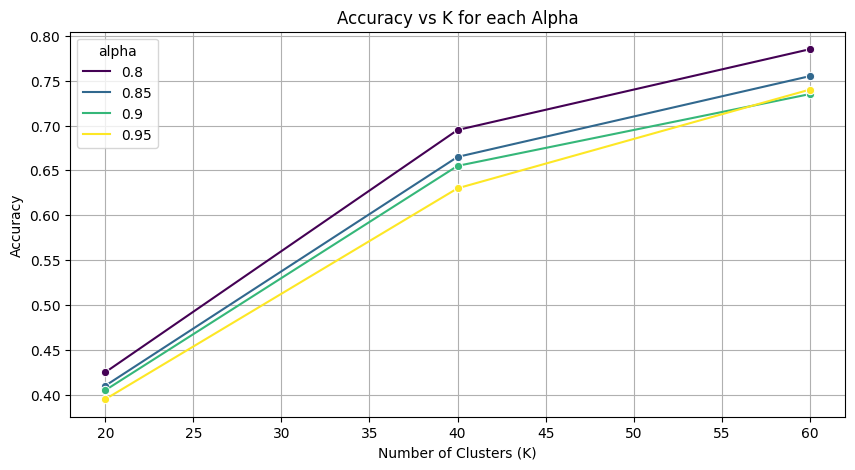

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

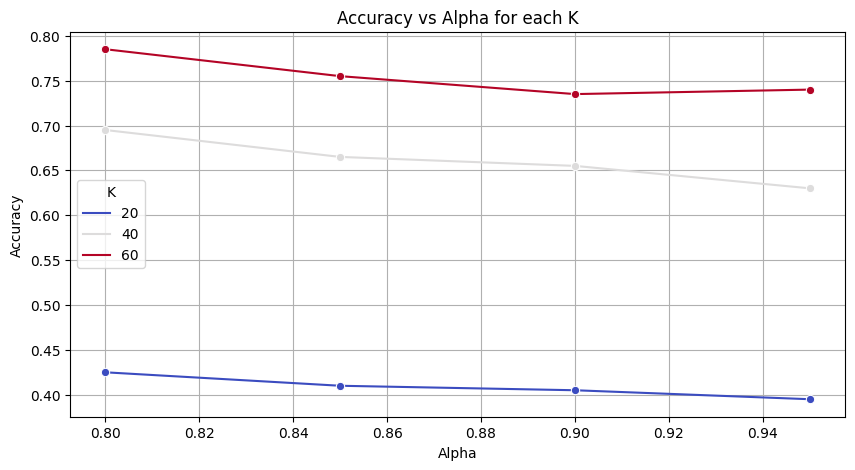

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the DataFrame
data = [
    (0.8, 20, 0.4250),
    (0.8, 40, 0.6950),
    (0.8, 60, 0.7850),
    (0.85, 20, 0.4100),
    (0.85, 40, 0.6650),
    (0.85, 60, 0.7550),
    (0.9, 20, 0.4050),
    (0.9, 40, 0.6550),
    (0.9, 60, 0.7350),
    (0.95, 20, 0.3950),
    (0.95, 40, 0.6300),
    (0.95, 60, 0.7400),
]

df = pd.DataFrame(data, columns=['alpha', 'K', 'accuracy'])

# Plot 1: Accuracy vs K (line per alpha)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='K', y='accuracy', hue='alpha', marker='o', palette='viridis')
plt.title('Accuracy vs K for each Alpha')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot 2: Accuracy vs Alpha (line per K)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='alpha', y='accuracy', hue='K', marker='o', palette='coolwarm')
plt.title('Accuracy vs Alpha for each K')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [93]:
K_values = [20, 40, 60]

results = []

for alpha in alphas:
    X_train = reduced_trains[alpha]
    for K in K_values:
        gmm = GMM(n_components = K, max_iter = 100, tol = 1e-4)
        gmm.fit(X_train)
        predicted_labels = map_clusters_to_labels(gmm.predict(X_train), y_train, K)
        acc = accuracy_score(y_train, predicted_labels)
        results.append((alpha, K, acc))
        print(f"Alpha: {alpha}, K: {K} → Accuracy: {acc:.4f}")

Alpha: 0.8, K: 20 → Accuracy: 0.3550
Alpha: 0.8, K: 40 → Accuracy: 0.5700
Alpha: 0.8, K: 60 → Accuracy: 0.7350
Alpha: 0.85, K: 20 → Accuracy: 0.3050
Alpha: 0.85, K: 40 → Accuracy: 0.5900
Alpha: 0.85, K: 60 → Accuracy: 0.7100
Alpha: 0.9, K: 20 → Accuracy: 0.2950
Alpha: 0.9, K: 40 → Accuracy: 0.4450
Alpha: 0.9, K: 60 → Accuracy: 0.6300
Alpha: 0.95, K: 20 → Accuracy: 0.2550
Alpha: 0.95, K: 40 → Accuracy: 0.4050
Alpha: 0.95, K: 60 → Accuracy: 0.5500


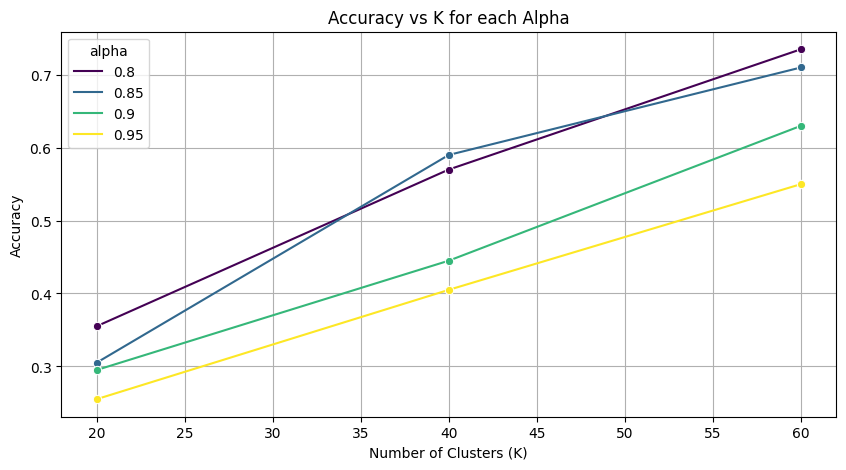

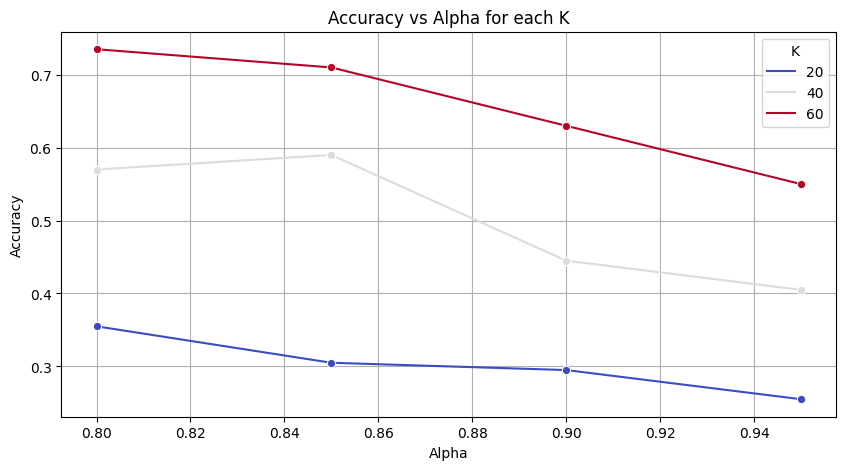

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the DataFrame
data = [
    (0.8, 20, 0.3550),
    (0.8, 40, 0.5700),
    (0.8, 60, 0.7350),
    (0.85, 20, 0.3050),
    (0.85, 40, 0.5900),
    (0.85, 60, 0.7100),
    (0.9, 20, 0.2950),
    (0.9, 40, 0.4450),
    (0.9, 60, 0.6300),
    (0.95, 20, 0.2550),
    (0.95, 40, 0.4050),
    (0.95, 60, 0.5500),
]

df = pd.DataFrame(data, columns=['alpha', 'K', 'accuracy'])

# Plot 1: Accuracy vs K (line per alpha)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='K', y='accuracy', hue='alpha', marker='o', palette='viridis')
plt.title('Accuracy vs K for each Alpha')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot 2: Accuracy vs Alpha (line per K)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='alpha', y='accuracy', hue='K', marker='o', palette='coolwarm')
plt.title('Accuracy vs Alpha for each K')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Results for K=60, alpha=0.8:
→ Accuracy: 0.8200
→ F1 Score: 0.8060


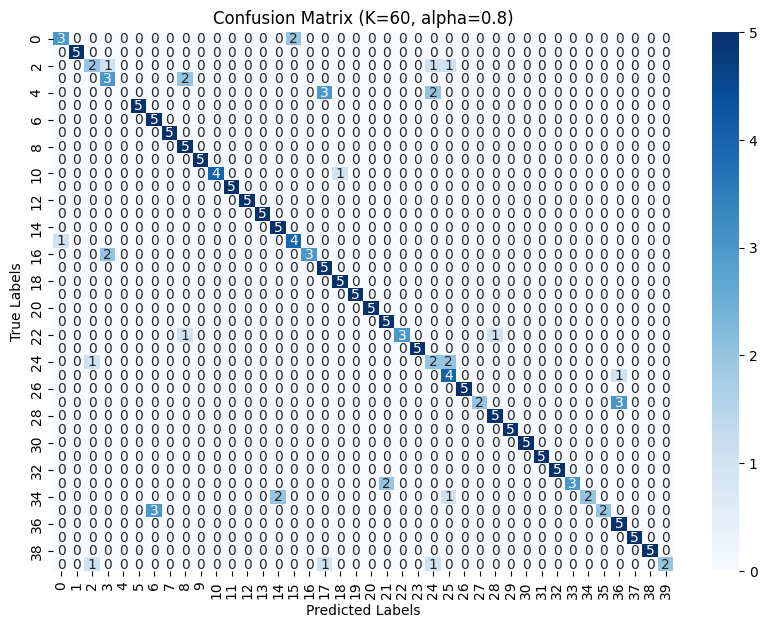

In [102]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Choose your desired K and alpha
K = 60  
alpha = 0.8  # Example alpha value (adjust based on your data)

# Get the reduced training data for the chosen alpha
X_test_reduced = reduced_tests[alpha]  

# Apply K-means clustering
kmeans = KMeansCustom(n_clusters=K, max_iter=100, tol=1e-4, random_state=42)
kmeans.fit(X_test_reduced)

# Map clusters to true labels
predicted_labels = map_clusters_to_labels(kmeans.labels, y_test, K)  

# Compute metrics
accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')  # Use 'macro' or 'micro' if needed
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print results
print(f"Results for K={K}, alpha={alpha}:")
print(f"→ Accuracy: {accuracy:.4f}")
print(f"→ F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (K={K}, alpha={alpha})")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Results for K=60, alpha=0.8:
→ Accuracy: 0.7650
→ F1 Score: 0.7524


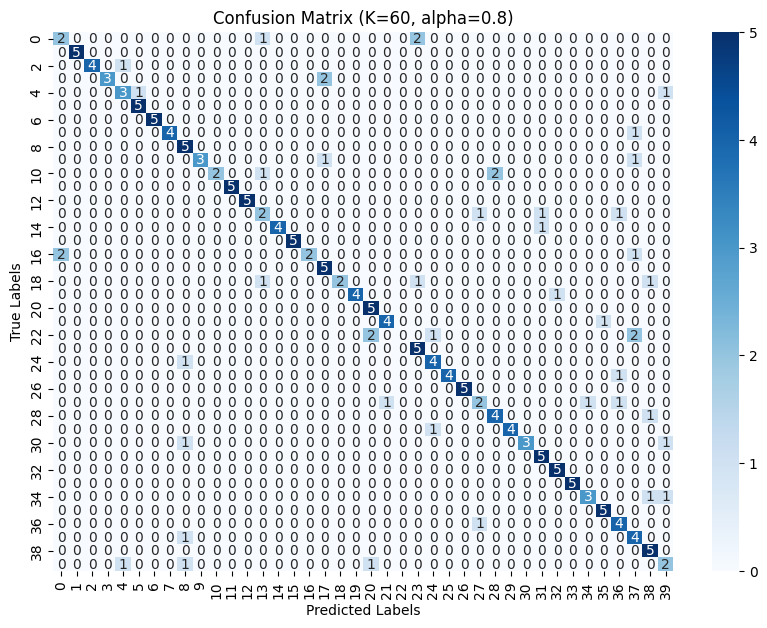

In [108]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

        # gmm = GMM(n_components = K, max_iter = 100, tol = 1e-4)
        # gmm.fit(X_train)
        # predicted_labels = map_clusters_to_labels(gmm.predict(X_train), y_train, K)
        # acc = accuracy_score(y_train, predicted_labels)
        # results.append((alpha, K, acc))
        # print(f"Alpha: {alpha}, K: {K} → Accuracy: {acc:.4f}")


# Choose your desired K and alpha
K = 60  
alpha = 0.8  # Example alpha value (adjust based on your data)

# Get the reduced training data for the chosen alpha
X_test_reduced = reduced_tests[alpha]  

# Apply K-means clustering
gmm = GMM(n_components=K, max_iter=100, tol=1e-4)
gmm.fit(X_test_reduced)

# Map clusters to true labels
predicted_labels = map_clusters_to_labels(gmm.predict(X_test_reduced), y_test, K)  

# Compute metrics
accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')  # Use 'macro' or 'micro' if needed
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print results
print(f"Results for K={K}, alpha={alpha}:")
print(f"→ Accuracy: {accuracy:.4f}")
print(f"→ F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (K={K}, alpha={alpha})")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# GMM

In [61]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal
from scipy.special import logsumexp  # Added missing import


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10, early_stop=1):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.early_stop = early_stop
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        
        self.converged_ = False

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for init in range(self.n_init):
            if self.verbose:
                print(f"Model #: {init}")
            self.__fit(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w
        return self

    def __fit(self, X):
        n_samples, n_features = X.shape
        
        # Initialize means with random samples - ensure they're truly different from each other
        idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[idx].copy()
        
        # Add small random perturbations to ensure uniqueness
        self.means_ += np.random.normal(0, 0.01, self.means_.shape)
        
        # Initialize covariances with data variance - ensure they're different for each component
        base_cov = np.eye(n_features) * np.var(X, axis=0)
        self.covariances_ = np.array([
            base_cov * (0.5 + np.random.rand()) + self.reg_covar 
            for _ in range(self.n_components)
        ])
        
        # Initialize with slightly different weights to break symmetry
        raw_weights = np.random.rand(self.n_components) + 0.5
        self.weights_ = raw_weights / np.sum(raw_weights)

        log_likelihood_old = -np.inf
        patience = self.early_stop
        no_improvement_count = 0

        # Debug
        if self.verbose:
            print(f"Initial weights: {self.weights_}")
            print(f"Initial means shape: {self.means_.shape}")
            print(f"Initial covariances shape: {self.covariances_.shape}")

        for iteration in range(self.max_iter):
            if self.verbose and iteration % 10 == 0:
                print(f"Iteration: {iteration} -> log_likelihood_old -> {log_likelihood_old}")
            
            # E-step: calculate responsibilities - vectorized version
            weighted_log_prob = np.zeros((n_samples, self.n_components))
            
            for k in range(self.n_components):
                # Try-except to catch singular matrix errors
                try:
                    log_pdf = multivariate_normal.logpdf(
                        X, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
                    weighted_log_prob[:, k] = np.log(self.weights_[k]) + log_pdf
                except Exception as e:
                    if self.verbose:
                        print(f"Warning in component {k}: {e}")
                    # Fallback to a more robust approach
                    cov_regularized = self.covariances_[k] + np.eye(n_features) * self.reg_covar * 10
                    log_pdf = multivariate_normal.logpdf(
                        X, mean=self.means_[k], cov=cov_regularized, allow_singular=True)
                    weighted_log_prob[:, k] = np.log(self.weights_[k]) + log_pdf
            
            # Normalize log probabilities for numerical stability
            log_prob_norm = logsumexp(weighted_log_prob, axis=1)
            log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
            resp = np.exp(log_resp)
            
            # Ensure no numerical issues
            resp = np.maximum(resp, np.finfo(resp.dtype).tiny)
            row_sums = resp.sum(axis=1, keepdims=True)
            resp = resp / row_sums  # Ensure each row sums to 1.0
            
            # Debug
            if self.verbose and iteration % 10 == 0:
                component_resp_sums = resp.sum(axis=0)
                print(f"Component responsibility sums: {component_resp_sums}")
                print(f"Min resp: {resp.min()}, Max resp: {resp.max()}")
            
            # M-step: update parameters
            for k in range(self.n_components):
                resp_sum = np.sum(resp[:, k])
                
                if self.verbose and iteration == 0:
                    print(f"resp_sum for component {k}: {resp_sum}")
                
                if resp_sum > 1e-6:  # Prevent division by very small numbers
                    # Update weights
                    self.weights_[k] = resp_sum / n_samples
                    
                    # Update means
                    weighted_sum = np.sum(resp[:, k, np.newaxis] * X, axis=0)
                    self.means_[k] = weighted_sum / resp_sum
                    
                    # Update covariances with careful handling
                    diff = X - self.means_[k]
                    
                    # Method 1: Direct calculation
                    weighted_diff = resp[:, k, np.newaxis] * diff
                    cov = np.dot(weighted_diff.T, diff) / resp_sum
                    
                    # Ensure positive definiteness
                    min_eig = np.min(np.linalg.eigvalsh(cov))
                    if min_eig < self.reg_covar:
                        cov.flat[::n_features + 1] += (self.reg_covar - min_eig)
                    
                    self.covariances_[k] = cov
                else:
                    # Handle the degenerate case - reinitialize this component
                    if self.verbose:
                        print(f"Reinitializing component {k} due to small responsibility sum")
                    self.weights_[k] = 1e-3  # Small but non-zero weight
                    self.means_[k] = X[np.random.choice(n_samples)] + np.random.normal(0, 0.01, n_features)
                    self.covariances_[k] = np.eye(n_features) * np.var(X, axis=0) * np.random.rand() + self.reg_covar

            # Normalize weights to sum to 1
            self.weights_ = self.weights_ / np.sum(self.weights_)
            
            # Check for convergence
            try:
                current_log_likelihood = self.score(X)
                if self.verbose and iteration % 10 == 0:
                    print(f"Log-likelihood: {current_log_likelihood}")
                    
                if np.abs(current_log_likelihood - log_likelihood_old) < self.tol:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= patience:
                    self.converged_ = True
                    if self.verbose:
                        print(f"Early stopping at iteration {iteration}")
                    break
                    
                log_likelihood_old = current_log_likelihood
            except Exception as e:
                if self.verbose:
                    print(f"Error in convergence check: {e}")
                # Continue anyway with adjusted parameters

    def predict(self, X):
        if self.means_ is None:
            raise ValueError("Model not fitted yet.")
            
        n_samples = len(X)
        log_responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            try:
                # Use log space for numerical stability
                log_responsibilities[:, k] = np.log(self.weights_[k] + 1e-10) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            except Exception as e:
                # Handle potential numerical issues
                regularized_cov = self.covariances_[k] + np.eye(self.covariances_[k].shape[0]) * self.reg_covar * 10
                log_responsibilities[:, k] = np.log(self.weights_[k] + 1e-10) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=regularized_cov, allow_singular=True)
        
        # Convert log responsibilities to probabilities and find the max
        return np.argmax(log_responsibilities, axis=1)

    def score(self, X):
        if self.means_ is None:
            raise ValueError("Model not fitted yet.")
            
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            try:
                log_prob[:, k] = np.log(max(self.weights_[k], 1e-10)) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            except Exception as e:
                # Handle potential numerical issues
                regularized_cov = self.covariances_[k] + np.eye(self.covariances_[k].shape[0]) * self.reg_covar * 10
                log_prob[:, k] = np.log(max(self.weights_[k], 1e-10)) + multivariate_normal.logpdf(
                    X, mean=self.means_[k], cov=regularized_cov, allow_singular=True)
        
        # Use logsumexp for numerical stability
        return np.sum(logsumexp(log_prob, axis=1))

# **Evaluation**

In [62]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.special import logsumexp

import numpy as np

def clusters_meaning(X, y, n_pred_clusters, n_classes):
    # print(len(np.unique(X)), len(np.unique(y)))
    cluster_map = np.zeros((n_pred_clusters, n_classes), dtype=int)
    # print(X, y)
    for i in range(len(X)):
        cluster_map[X[i], y[i]-1] += 1

    cluster_meanings = np.zeros(n_pred_clusters, dtype=int)
    for i, row in enumerate(cluster_map):
        cluster_meanings[i] = np.argmax(row)
    return cluster_meanings

# Ensure X, y are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_components_list = [20, 40, 60]
# n_components_list = [40]

for n in n_components_list:
    print(f"\n===== n_components = {n} =====")

    # ▶ Custom GMM
    gmm = GMM(n_components=n, max_iter=50, tol=1e-3, n_init=3, verbose=False)
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    y_pred_sklearn_mapped = clusters_meaning(y_pred, y_test, n, 40)[y_pred]
    
    acc_sklearn = accuracy_score(y_test, y_pred_sklearn_mapped)
    f1_sklearn = f1_score(y_test, y_pred_sklearn_mapped, average='macro')
    
    print("\n[GMM]")
    print(f"Accuracy: {acc_sklearn:.4f}")
    print(f"F1 Score:  {f1_sklearn:.4f}")
    print(confusion_matrix(y_test, y_pred_sklearn_mapped))

    # ▶ Sklearn GaussianMixture
    gmm = GaussianMixture(n_components=n, max_iter=50, tol=1e-3, n_init=3, random_state=42)
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    y_pred_sklearn_mapped = clusters_meaning(y_pred, y_test, n, 40)[y_pred]
    
    acc_sklearn = accuracy_score(y_test, y_pred_sklearn_mapped)
    f1_sklearn = f1_score(y_test, y_pred_sklearn_mapped, average='macro')

    print("\n[Sklearn GMM]")
    print(f"Accuracy: {acc_sklearn:.4f}")
    print(f"F1 Score:  {f1_sklearn:.4f}")
    print(confusion_matrix(y_test, y_pred_sklearn_mapped))

    # ▶ KNN
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)

    acc_knn = accuracy_score(y_test, y_pred_knn)
    f1_knn = f1_score(y_test, y_pred_knn, average='macro')

    print("\n[KNN]")
    print(f"Accuracy: {acc_knn:.4f}")
    print(f"F1 Score:  {f1_knn:.4f}")
    print(confusion_matrix(y_test, y_pred_knn))


===== n_components = 20 =====

[GMM]
Accuracy: 0.0200
F1 Score:  0.0041
[[0 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

[Sklearn GMM]
Accuracy: 0.0100
F1 Score:  0.0042
[[2 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

[KNN]
Accuracy: 0.5600
F1 Score:  0.4925
[[2 1 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

===== n_components = 40 =====

[GMM]
Accuracy: 0.0100
F1 Score:  0.0067
[[0 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

[Sklearn GMM]
Accuracy: 0.0000
F1 Score:  0.0000
[[0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

[KNN]
Accuracy: 0.2950
F1 Score:  0.2244
[[2 1 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 

# **Bouns Part**

## **Define Autoencoder Architecture**

In [109]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # Block 1: 2 Conv + MaxPool (112x92 → 56x46)
            nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 112x92 → 56x46
        
            # Block 2: 2 Conv + MaxPool (56x46 → 28x23)
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 56x46 → 28x23
        
            # Block 3: 2 Conv + MaxPool (28x23 → 14x12)
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ZeroPad2d((0, 1, 0, 0)),  # Pad right side of width by 1 (23 → 24)
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 28x24 → 14x12
        
            # Block 4: 2 Conv + MaxPool (14x12 → 7x6)
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # 14x12 → 7x6
        )

        self.decoder = nn.Sequential(
            # Block 1: 7x6 → 14x12
            nn.ConvTranspose2d(1, 32, kernel_size = 2, stride = 2),  # 7x6 → 14x12
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Block 2: 14x12 → 28x23 (with cropping)
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2),  # 14x12 → 28x24
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConstantPad2d((0, -1, 0, 0), value = 0),  # Crop right by 1 pixel: 24 → 23
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Block 3: 28x23 → 56x46
            nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2),  # 28x23 → 56x46
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            # Block 4: 56x46 → 112x92 (final upscale)
            nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2),  # 56x46 → 112x92
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size = 3, stride = 1, padding = 1),
            nn.Sigmoid(),  # Normalize to [0, 1]
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstruct = self.decoder(embedding)
        return embedding, reconstruct

## **Define Loss, Optimizer, and learning rate Scheduler** 

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

## **Create Custom Dataset**

In [111]:
class FaceDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        img.resize((112, 92))
        
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).float()
            img = img.unsqueeze(0)
        return img, img

## **Create Dataloaders**

In [112]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.ToTensor(),
])

train_idx, val_idx = train_test_split(np.arange(len(train_data)), test_size = 0.2, random_state = 42)
train_images = train_data[train_idx]
val_images   = train_data[val_idx]

train_dataset = FaceDataset(train_images, transform = train_transform)
val_dataset   = FaceDataset(val_images)

batch_size   = 4
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader   = DataLoader(val_dataset, batch_size   = batch_size, shuffle = False)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 10, factor = 0.5)


In [113]:
# Training parameters
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Batch training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        _, output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            _, output = model(data)
            
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
    
    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    val_loss   /= len(val_loader.dataset)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    if epoch % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')

# Save final model
torch.save(model.state_dict(), 'final_autoencoder.pth')
print('Training complete!')

Epoch [1/100], Train Loss: 0.0225, Val Loss: 0.0386, LR: 1.00e-03
Epoch [6/100], Train Loss: 0.0117, Val Loss: 0.0106, LR: 1.00e-03
Epoch [11/100], Train Loss: 0.0110, Val Loss: 0.0103, LR: 1.00e-03
Epoch [16/100], Train Loss: 0.0114, Val Loss: 0.0091, LR: 1.00e-03
Epoch [21/100], Train Loss: 0.0105, Val Loss: 0.0089, LR: 1.00e-03
Epoch [26/100], Train Loss: 0.0097, Val Loss: 0.0093, LR: 1.00e-03
Epoch [31/100], Train Loss: 0.0103, Val Loss: 0.0088, LR: 1.00e-03
Epoch [36/100], Train Loss: 0.0099, Val Loss: 0.0092, LR: 1.00e-03
Epoch [41/100], Train Loss: 0.0109, Val Loss: 0.0092, LR: 1.00e-03
Epoch [46/100], Train Loss: 0.0093, Val Loss: 0.0088, LR: 5.00e-04
Epoch [51/100], Train Loss: 0.0089, Val Loss: 0.0088, LR: 5.00e-04
Epoch [56/100], Train Loss: 0.0091, Val Loss: 0.0082, LR: 5.00e-04
Epoch [61/100], Train Loss: 0.0087, Val Loss: 0.0092, LR: 5.00e-04
Epoch [66/100], Train Loss: 0.0090, Val Loss: 0.0088, LR: 5.00e-04
Epoch [71/100], Train Loss: 0.0083, Val Loss: 0.0097, LR: 5.00e-

## **Evaluate Autoencoder on Test Data**

In [114]:
checkpoint_path = 'best_autoencoder.pth'
model.load_state_dict(torch.load(checkpoint_path))

model.eval()

with torch.no_grad():
    total_test_loss = 0

    for index in range(len(test_data)):
        img = test_data[index]
        img.resize((112, 92))
        
        img = torch.from_numpy(img).float()
        img = img.unsqueeze(0).unsqueeze(0)
        img = img
        
        img = img.to(device)
        
        _, output = model(img)

        loss = criterion(output, img)
        total_test_loss += loss.item()

    average_test_loss = total_test_loss / len(test_data)
    print(f'\nTest Loss: {average_test_loss:.4f}')


Test Loss: 0.0073


## **Display The Reconstructed Image**

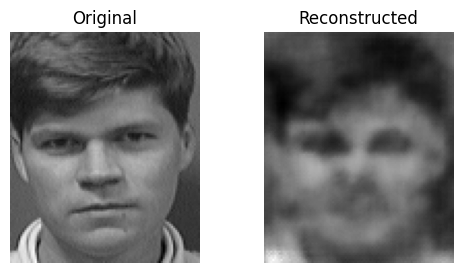

In [116]:
model.eval()

img = test_data[50]   
img.resize((112, 92))

# Prepare the image
img_tensor = torch.from_numpy(img).float()
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device)
img_tensor = img_tensor

# Forward pass
with torch.no_grad():
    _, reconstructed = model(img_tensor)

# Convert back to numpy
original_img = img_tensor.squeeze().cpu().numpy()
reconstructed_img = reconstructed.squeeze().cpu().numpy()

# Plot
plt.figure(figsize=(6,3))

# Original
plt.subplot(1,2,1)
plt.imshow(original_img, cmap='gray')
plt.title('Original')
plt.axis('off')

# Reconstructed
plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed')
plt.axis('off')

plt.show()

## **Extract Embedding Part**

In [117]:
model.eval()

def get_embeddings(data, model, batch_size = 200, device = 'cpu'):
    # Reshape (N, 112*92) → (N, 1, 112, 92)
    data_images = data.reshape(-1, 1, 112, 92).astype(np.float32)
    tensor_data = torch.tensor(data_images)
    dataset     = TensorDataset(tensor_data)
    dataloader  = DataLoader(dataset, batch_size = batch_size, shuffle = False)

    embeddings = []

    with torch.no_grad():
        for (batch,) in dataloader:
            batch        = batch.to(device)
            embedding, _ = model(batch)
            flat         = embedding.view(batch.size(0), -1)  # Flatten each embedding
            embeddings.append(flat.cpu())

    return torch.cat(embeddings, dim=0).numpy()

embedding_train = get_embeddings(train_data, model, 200,  device)
embedding_test  = get_embeddings(test_data, model, 200,  device)

Results for K=60:
→ Accuracy: 0.7700
→ F1 Score: 0.7452


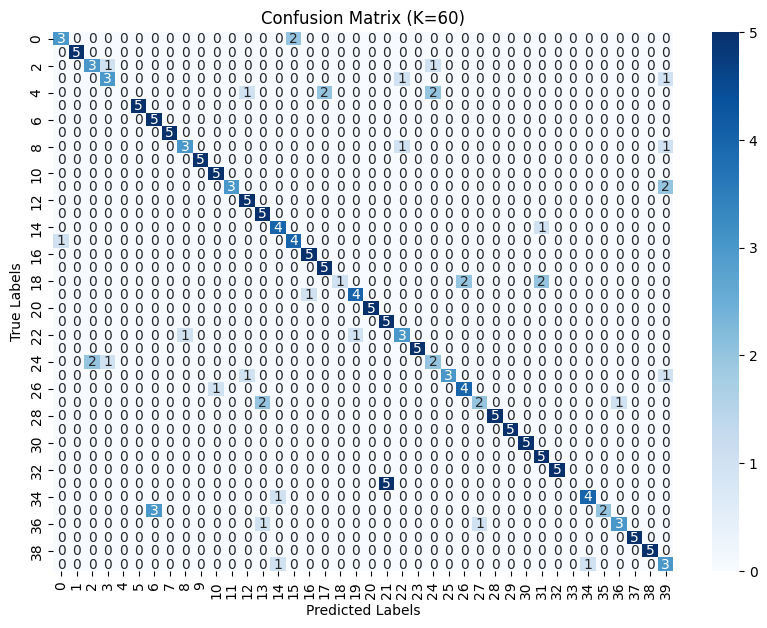

In [119]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Choose your desired K and alpha
K = 60  
alpha = 0.8  # Example alpha value (adjust based on your data)

# Get the reduced training data for the chosen alpha
X_test_reduced = embedding_test  

# Apply K-means clustering
kmeans = KMeansCustom(n_clusters=K, max_iter=100, tol=1e-4, random_state=42)
kmeans.fit(X_test_reduced)

# Map clusters to true labels
predicted_labels = map_clusters_to_labels(kmeans.labels, y_test, K)  

# Compute metrics
accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')  # Use 'macro' or 'micro' if needed
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print results
print(f"Results for K={K}:")
print(f"→ Accuracy: {accuracy:.4f}")
print(f"→ F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (K={K})")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Results for K=60:
→ Accuracy: 0.7450
→ F1 Score: 0.7194


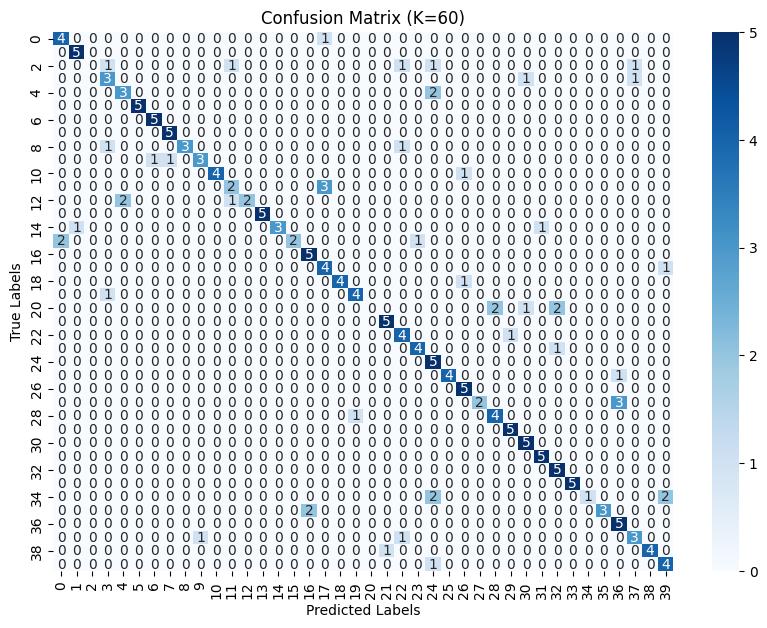

In [121]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Choose your desired K and alpha
K = 60  
alpha = 0.8  # Example alpha value (adjust based on your data)

# Get the reduced training data for the chosen alpha
X_test_reduced = embedding_test

# Apply K-means clustering
gmm = GMM(n_components=K, max_iter=100, tol=1e-4)
gmm.fit(X_test_reduced)

# Map clusters to true labels
predicted_labels = map_clusters_to_labels(gmm.predict(X_test_reduced), y_test, K)  

# Compute metrics
accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')  # Use 'macro' or 'micro' if needed
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print results
print(f"Results for K={K}:")
print(f"→ Accuracy: {accuracy:.4f}")
print(f"→ F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (K={K})")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [123]:
K_values = [20, 40, 60]

results = []


X_train = embedding_train
for K in K_values:
    kmeans = KMeansCustom(n_clusters=K, max_iter=100, tol=1e-4, random_state=42)
    kmeans.fit(X_train)
    predicted_labels = map_clusters_to_labels(kmeans.labels, y_train, K)
    acc = accuracy_score(y_train, predicted_labels)
    results.append((alpha, K, acc))
    print(f"K: {K} → Accuracy: {acc:.4f}")

K: 20 → Accuracy: 0.4200
K: 40 → Accuracy: 0.6200
K: 60 → Accuracy: 0.7400


In [124]:
K_values = [20, 40, 60]

results = []


X_train = embedding_train
for K in K_values:
    gmm = GMM(n_components = K, max_iter = 100, tol = 1e-4)
    gmm.fit(X_train)
    predicted_labels = map_clusters_to_labels(gmm.predict(X_train), y_train, K)
    acc = accuracy_score(y_train, predicted_labels)
    results.append((alpha, K, acc))
    print(f"Alpha: {alpha}, K: {K} → Accuracy: {acc:.4f}")

Alpha: 0.8, K: 20 → Accuracy: 0.4000
Alpha: 0.8, K: 40 → Accuracy: 0.6000
Alpha: 0.8, K: 60 → Accuracy: 0.7550
